In [1]:
import pandas as pd
from pycirclize import Circos
from matplotlib.patches import Patch
import numpy as np
import utils

In [2]:
# Color map

color_map = {
    "CRISPR": "#d55e00cc",
    "Target2": "#0072b2cc",
    "Control": "#cc79a7cc",
}

In [3]:
wells = pd.read_csv("../datasets/metadata/well.csv.gz").query(
    "Metadata_Source=='source_13'"
)[["Metadata_Plate", "Metadata_Well", "Metadata_JCP2022"]]
plates = pd.read_csv("../datasets/metadata/plate.csv.gz").query(
    "Metadata_Source=='source_13'"
)[["Metadata_Batch", "Metadata_Plate", "Metadata_PlateType"]]

crispr = pd.read_csv("../00.download-and-process-annotations/output/crispr.csv.gz")

crispr_metadata = (
    wells.merge(plates, on="Metadata_Plate", how="inner")
    .merge(crispr, on="Metadata_JCP2022", how="left")
    .sort_values(by=["Metadata_Plate", "Metadata_Well"])
    .reset_index(drop=True)
    .replace({"TARGET2": "Target2"})
)

crispr_metadata.head()

,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_NCBI_Gene_ID,Metadata_Symbol,Metadata_Approved_Symbol
0,CP-CC9-R1-01,A01,JCP2022_085227,20220914_Run1,CRISPR,NaN,NaN,NaN
1,CP-CC9-R1-01,A02,JCP2022_800002,20220914_Run1,CRISPR,NaN,non-targeting,NaN
2,CP-CC9-R1-01,A03,JCP2022_800573,20220914_Run1,CRISPR,8874.0,ARHGEF7,ARHGEF7
3,CP-CC9-R1-01,A04,JCP2022_806794,20220914_Run1,CRISPR,6767.0,ST13,ST13
4,CP-CC9-R1-01,A05,JCP2022_802800,20220914_Run1,CRISPR,10243.0,GPHN,GPHN


In [4]:
# Infer platemap for all plates

platemap_df = utils.infer_platemap(
    crispr_metadata.rename(
        columns={"Metadata_Symbol": "Symbol", "Metadata_Plate": "Plate"}
    )
).rename(columns={"Platemap": "Metadata_Platemap", "Plate": "Metadata_Plate"})

platemap_df.head()

,Metadata_Plate,Metadata_Platemap
0,CP-CC9-R1-01,platemap_1
1,CP-CC9-R1-02,platemap_2
2,CP-CC9-R1-03,platemap_3
3,CP-CC9-R1-04,platemap_4
4,CP-CC9-R1-05,platemap_5


In [5]:
# List all control plates: plates with only two kinds of samples 

control_plates = list(
    crispr_metadata.groupby("Metadata_Plate")
    .agg({"Metadata_JCP2022": "nunique"})
    .query("Metadata_JCP2022 == 2")
    .index.values
)

crispr_metadata["Metadata_PlateType"] = np.where(
    crispr_metadata["Metadata_Plate"].isin(control_plates),
    "Control",
    crispr_metadata["Metadata_PlateType"],
)

In [6]:
# Keep only one row per plate

crispr_metadata = (
    crispr_metadata.drop_duplicates(subset=["Metadata_Plate"], keep="first")
    .reset_index(drop=True)
)[["Metadata_Batch", "Metadata_Plate", "Metadata_PlateType"]]

crispr_metadata.head()

,Metadata_Batch,Metadata_Plate,Metadata_PlateType
0,20220914_Run1,CP-CC9-R1-01,CRISPR
1,20220914_Run1,CP-CC9-R1-02,CRISPR
2,20220914_Run1,CP-CC9-R1-03,CRISPR
3,20220914_Run1,CP-CC9-R1-04,CRISPR
4,20220914_Run1,CP-CC9-R1-05,CRISPR


In [7]:
# Add Platemap information

crispr_metadata = crispr_metadata.merge(platemap_df, on="Metadata_Plate", how="left")

In [8]:
# Create batch name

crispr_metadata["Batch"] = crispr_metadata["Metadata_Batch"].apply(
    lambda x: f"Batch{int(x[-1:]):02}"
)

In [9]:
# Sort the dataframe by Batch and Plate Name

crispr_metadata = crispr_metadata.sort_values(
    by=["Batch", "Metadata_Plate"],
).reset_index(drop=True)

In [10]:
# Number of plates per platemap per perturbation type per batch

n_plates_platemap_perturbation_batch = (
    crispr_metadata.groupby(["Batch", "Metadata_PlateType", "Metadata_Platemap"])
    .agg({"Metadata_Plate": "count"})
    .reset_index()
)

n_plates_platemap_perturbation_batch.head()

,Batch,Metadata_PlateType,Metadata_Platemap,Metadata_Plate
0,Batch01,CRISPR,platemap_1,1
1,Batch01,CRISPR,platemap_10,1
2,Batch01,CRISPR,platemap_11,1
3,Batch01,CRISPR,platemap_12,1
4,Batch01,CRISPR,platemap_13,1


In [11]:
# Number of plates per perturbation type per batch

n_plates_perturbation_batch = (
    n_plates_platemap_perturbation_batch.groupby(["Batch", "Metadata_PlateType"])
    .agg({"Metadata_Plate": "sum"})
    .reset_index()
)

n_plates_perturbation_batch.head()

,Batch,Metadata_PlateType,Metadata_Plate
0,Batch01,CRISPR,27
1,Batch01,Control,1
2,Batch01,Target2,1
3,Batch02,CRISPR,27
4,Batch02,Control,1


In [12]:
# Number of plates per batch

n_plates_batch = (
    n_plates_perturbation_batch.groupby("Batch")
    .agg({"Metadata_Plate": "sum"})
    .reset_index()
)

n_plates_batch.head()

,Batch,Metadata_Plate
0,Batch01,29
1,Batch02,29
2,Batch03,29
3,Batch04,26
4,Batch05,33


In [13]:
# Create pycirclize sectors

sectors = dict(zip(n_plates_batch.Batch, n_plates_batch.Metadata_Plate))

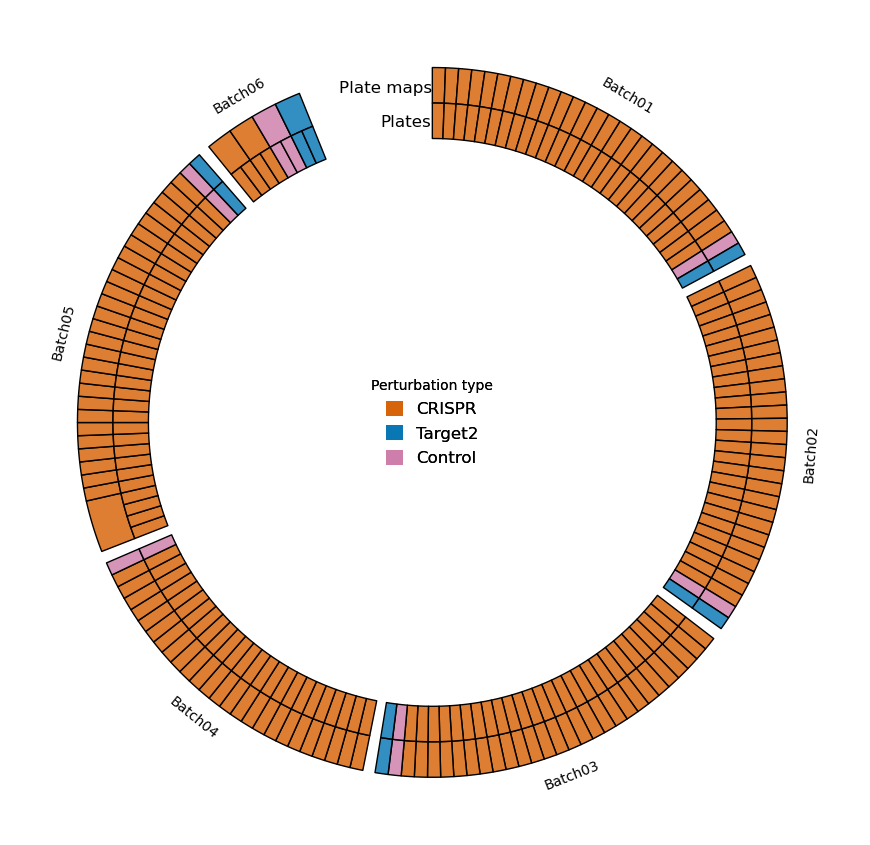

In [14]:
# Draw circos plot

circos = Circos(sectors, space=2, start=0, end=340)

for sector in circos.sectors:
    sector.text(sector.name)

    # Draw plate map level

    platemap_counter = 0

    for platemap in n_plates_platemap_perturbation_batch.query(
        "Batch==@sector.name"
    ).Metadata_Platemap.unique():
        n_plates_platemap = n_plates_platemap_perturbation_batch.query(
            "Batch==@sector.name & Metadata_Platemap==@platemap"
        ).Metadata_Plate.values[0]
        pert_type = n_plates_platemap_perturbation_batch.query(
            "Batch==@sector.name & Metadata_Platemap==@platemap"
        ).Metadata_PlateType.values[0]

        sector.rect(
            start=platemap_counter,
            end=platemap_counter + n_plates_platemap,
            r_lim=(90, 100),
            fc=color_map[pert_type],
            ec="black",
            lw=1,
        )

        platemap_counter += n_plates_platemap

    # Draw plate level

    plate_counter = 0
    for pert_type in n_plates_perturbation_batch.query(
        "Batch==@sector.name"
    ).Metadata_PlateType.unique():
        n_plates = n_plates_perturbation_batch.query(
            "Batch==@sector.name & Metadata_PlateType==@pert_type"
        ).Metadata_Plate.values[0]

        for i in range(plate_counter, plate_counter + n_plates):
            sector.rect(
                start=i,
                end=i + 1,
                r_lim=(80, 90),
                fc=color_map[pert_type],
                ec="black",
                lw=1,
            )
        plate_counter += n_plates

# Add text
circos.text("Plate maps", r=95, deg=352, size=12, color="black")
circos.text("Plates", r=85, deg=355, size=12, color="black")

fig = circos.plotfig()

pert_type_handles = []

for pert_type in color_map:
    pert_type_handles.append(Patch(color=color_map[pert_type], label=pert_type))

pert_type_legend = circos.ax.legend(
    handles=pert_type_handles,
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    fontsize=12,
    title="Perturbation type",
)

circos.ax.add_artist(pert_type_legend)

fig.savefig("figures/crispr_experiment_circos.png", dpi=300, transparent=True)
fig.savefig("figures/crispr_experiment_circos.svg", dpi=300, transparent=True)